In [1]:
# User
user = "nk1922"

# Imports
import torch
from torch import nn
from torch.distributions import Normal,Laplace,Uniform
import matplotlib.pyplot as plt
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

os.chdir('C:/Users/{0}/OneDrive/Documents/Cocycles project/Cocycle_code'.format(user))
from Cocycle_CDAGM import *
from Cocycle_model import *
from Cocycle_optimise import *
from Cocycle_preprocess import *
from Cocycle_loss_functions import *
from Conditioners import *
from Transformers import *
from Helper_functions import *
from KDE_estimation import *
from Kernels import *
os.chdir('C:/Users/{0}/OneDrive/Documents/Cocycles project/Flows_code'.format(user))
from RQS import *
os.chdir('C:/Users/{0}/OneDrive/Documents/Cocycles project/Experiments_code'.format(user))
from Csuite import Nonlin_Gauss_chain as DGP
from Csuite import NonlinGausschain_conditioner as True_Conditioner
os.chdir('C:/Users/{0}/OneDrive/Documents/Cocycles project/Experimental_results'.format(user))

In [2]:
# Generating data
#torch.manual_seed(1)
N,Ntrue = 1000,10**6
intervention  = lambda a,x : a+x*0
a = 0
cate_levels = torch.linspace(-4,2,100)
Xobs_z,Xint_z = DGP(0, Ntrue ,True,intervention,[a],adversarial = False, CATE = True, CATE_levels = cate_levels)
Xobs = DGP(N, 0,False,adversarial = False)

TypeError: Nonlin_Gauss_chain() got an unexpected keyword argument 'CATE'

In [ ]:
# Marginal KDE_z
Y,Z = Xobs[:,2].view(N,1),Xobs[:,0].view(N,1)
kernel_z = inverse_gaussian_kernel(torch.ones(1,requires_grad = True),1)
KDE_z = KDE(kernel_z)
losses = KDE_z.optimise(Z,0.1,100,1000,0.01,5, reg = 1e-10);

# Marginal KDE_x
X = Xobs[:,1].view(N,1)
kernel_x = inverse_gaussian_kernel(torch.ones(1,requires_grad = True),1)
KDE_x = KDE(kernel_x)
losses = KDE_x.optimise(X,0.1,100,1000,0.01,5, reg = 1e-10);

# Joint KDE 
kernel_joint = inverse_gaussian_kernel(torch.ones(2,requires_grad = True),1)
KDE_joint = KDE(kernel_joint)
losses = KDE_joint.optimise(Xobs,0.1,100,1000,0.01,5, reg = 1e-10);

In [ ]:
# NW CV 
Y,Z = Xobs[:,2].view(N,1),Xobs[:,0].view(N,1)
kernel_z = inverse_gaussian_kernel(torch.ones(1,requires_grad = True),1)
KDE_NW = KDE(kernel_z)
losses = KDE_NW.optimise(torch.column_stack((Y,Z)),0.1,100,1000,0.01,5, reg = 1e-10, Loss = "CV");

In [ ]:
KDE_joint.kernel.lengthscale,KDE_z.kernel.lengthscale,KDE_x.kernel.lengthscale,KDE_NW.kernel.lengthscale

In [ ]:
# CLS estimation for every ind set
parents = [[],[0],[1]]
models = []
cocycle_loss = "CMMD_M_RFF"
RFF_features,nfeat = True,100
batch_size = 1024
maxiter = 5000
miniter = 1000 # 1*int(N*(N-1)/2/batch_size)
train_val_split = 0.8
med_heuristic = True
ntrain = int(train_val_split*N)
for i in range(len(parents)):
    if len(parents[i])>0:
        
        # Getting relevant variables from graph
        index_x,index_y = parents[i],[i]
        X,Y = Xobs[:,index_x].view(N,len(index_x)),Xobs[:,index_y].view(N,len(index_y))
        Xtrain,Ytrain,Xval,Yval = X[:ntrain],Y[:ntrain],X[ntrain:],Y[ntrain:]
        
        # Data Preprocessing
        if cocycle_loss in ["JMMD","CMR"]:
            inputs_train,outputs_train, = preprocess(independent_pairs = False,asymmetric_pairs = True)(Xtrain,Ytrain)
            if train_val_split != 1:
                inputs_val,outputs_val, = preprocess(independent_pairs = False,asymmetric_pairs = True)(Xval,Yval)
            else:
                inputs_val,outputs_val, = [],[]      
        else:
            if train_val_split == 1:
                inputs_train,outputs_train, inputs_val,outputs_val = X,Y,[],[]
            else:
                inputs_train,outputs_train, inputs_val,outputs_val = Xtrain,Ytrain,Xval,Yval
        
        # Getting loss function
        loss_fn = loss(loss_fn = cocycle_loss,kernel = [gaussian_kernel(torch.ones(1),1),gaussian_kernel(torch.ones(1),1)])
        if med_heuristic:
            loss_fn.median_heuristic(inputs_train,outputs_train, subsamples = 10**4)
        
        # Getting RFF features
        if RFF_features:
            loss_fn.get_RFF_features(nfeat)
        
        # Defining and training model
        conditioner = NN_Conditioner(width = 128, layers = 2, input_dims =  len(index_x), output_dims = len(index_y) ,bias = False)
        transformer = Shift_Transformer()
        model = cocycle_model([conditioner],transformer)
        model = train(model).optimise(loss_fn,inputs_train,outputs_train,inputs_val,outputs_val, batch_size = batch_size, conditioner_learn_rate = 1e-4,
                                      transformer_learn_rate = 1e-3,print_ = True,plot = False, miniter = miniter,maxiter = maxiter, val_tol = 1e-3, scheduler = True)
        models.append(model)
    else:
        models.append([])

In [ ]:
# True model construction
true_models = []
parents = [[],[0],[1]]
for i in range(len(parents)):
    true_models.append(cocycle_model([True_Conditioner(i)],Shift_Transformer()))
    
ccdagm_true = CCDAGM(models,parents)

EY_z_hat = torch.zeros(len(cate_levels)) 
for i in range(len(cate_levels)):
    Xt,Xint = ccdagm_true.interventional_dist_sample(Xobs,intervention,[cate_levels[i],"id","id"],10**5, uniform_subsample = False)
    EY_z_hat[i] = Xint[:,2].mean()

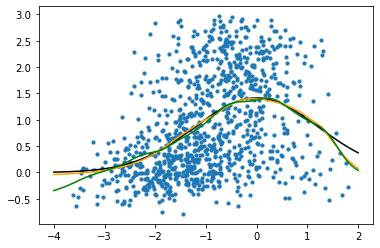

In [27]:
# Computing true conditional expectation
EY_z = torch.ones(len(Xobs_z))
for i in range(len(Xobs_z)):
    EY_z[i] = Xobs_z[i][:,2].mean()   
Ztest = cate_levels[:,None]
K = KDE_z.kernel.get_gram(Ztest,Z) 
Xpred = (K @ X)/K.sum(1)[:,None]
Kpred = KDE_x.kernel.get_gram(Xpred,X)
Ypred_conditional = (Kpred @ Y)/Kpred.sum(1)[:,None]
Ypred_z = (K @ Y)/K.sum(1)[:,None]
plt.scatter(Z.T,Y.T, s = 10)
plt.plot(Ztest[:,0],EY_z, color = "black");
plt.plot(Ztest[:,0],EY_z_hat, color = "orange");
plt.plot(Ztest,Ypred_z.detach(), color = "green");
#plt.plot(Ztest,Ypred_conditional.detach());